In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 99% 324M/329M [00:09<00:00, 30.3MB/s]
100% 329M/329M [00:09<00:00, 34.6MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/plant-village.zip','r')
zip_ref.extractall('/content/PlantVillage/')
zip_ref.close()

In [4]:
import os
import shutil

required_folders = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
os.makedirs('potato_dataset', exist_ok=True)

for folder in required_folders:
    shutil.move(f'/content/PlantVillage/PlantVillage/{folder}', 'potato_dataset/')

# Step 7: Verify the contents
!ls potato_dataset

Potato___Early_blight  Potato___healthy  Potato___Late_blight


In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "potato_dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 2 0 1 1 1 1 1]


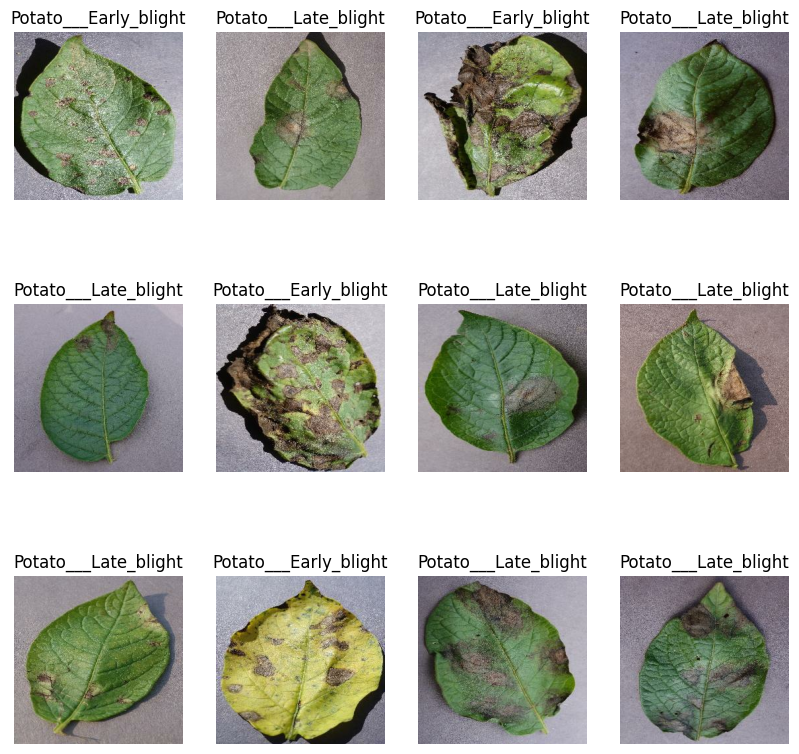

In [9]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [10]:
# 80% ==> Training
# 10% ==> Validation
# 10%==>TEST

In [11]:
training_size=0.8
len(dataset)*training_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(test_ds)

8

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

normalizing the image array

In [22]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.4627451  0.45490196 0.50980395]
  [0.43529412 0.42745098 0.48235294]
  [0.40784314 0.4        0.45490196]
  ...
  [0.5764706  0.5647059  0.6392157 ]
  [0.6313726  0.61960787 0.69411767]
  [0.5686275  0.5568628  0.6313726 ]]

 [[0.41960785 0.4117647  0.46666667]
  [0.40392157 0.39607844 0.4509804 ]
  [0.39607844 0.3882353  0.44313726]
  ...
  [0.57254905 0.56078434 0.63529414]
  [0.63529414 0.62352943 0.69803923]
  [0.63529414 0.62352943 0.69803923]]

 [[0.4117647  0.40392157 0.45882353]
  [0.40784314 0.4        0.45490196]
  [0.4117647  0.40392157 0.45882353]
  ...
  [0.5647059  0.5529412  0.627451  ]
  [0.57254905 0.56078434 0.63529414]
  [0.58431375 0.57254905 0.64705884]]

 ...

 [[0.4627451  0.47843137 0.5254902 ]
  [0.4745098  0.49019608 0.5372549 ]
  [0.5058824  0.52156866 0.5686275 ]
  ...
  [0.69411767 0.70980394 0.75686276]
  [0.6392157  0.654902   0.7019608 ]
  [0.69411767 0.70980394 0.75686276]]

 [[0.47843137 0.49411765 0.5411765 ]
  [0.48235294 0.49803922 0.54509807]


In [23]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])

In [26]:
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history=model.fit(
    train_ds,
    epochs=70,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/70
54/54 [==============================] - 14s 81ms/step - loss: 0.8896 - accuracy: 0.5266 - val_loss: 0.8019 - val_accuracy: 0.6244
Epoch 2/70
54/54 [==============================] - 4s 75ms/step - loss: 0.6928 - accuracy: 0.6944 - val_loss: 0.5873 - val_accuracy: 0.7390
Epoch 3/70
54/54 [==============================] - 4s 74ms/step - loss: 0.4648 - accuracy: 0.7998 - val_loss: 0.4347 - val_accuracy: 0.8247
Epoch 4/70
54/54 [==============================] - 4s 76ms/step - loss: 0.3546 - accuracy: 0.8565 - val_loss: 0.3645 - val_accuracy: 0.8455
Epoch 5/70
54/54 [==============================] - 4s 74ms/step - loss: 0.2827 - accuracy: 0.8831 - val_loss: 0.2412 - val_accuracy: 0.9028
Epoch 6/70
54/54 [==============================] - 4s 79ms/step - loss: 0.2285 - accuracy: 0.9097 - val_loss: 0.1673 - val_accuracy: 0.9340
Epoch 7/70
54/54 [==============================] - 4s 76ms/step - loss: 0.2272 - accuracy: 0.9103 - val_loss: 0.2526 - val_accuracy: 0.8900
Epoch 8/70
5

In [30]:
scores=model.evaluate(test_ds)

54/54 [==============================] - 1s 19ms/step - loss: 0.0255 - accuracy: 0.9907


In [31]:
scores

[0.025519076734781265, 0.9907407164573669]

In [32]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.5266203880310059,
 0.6944444179534912,
 0.7997685074806213,
 0.8564814925193787,
 0.8831018805503845,
 0.9097222089767456,
 0.9103009104728699,
 0.9143518805503845,
 0.9155092835426331,
 0.9357638955116272,
 0.9496527910232544,
 0.9311342835426331,
 0.9276620149612427,
 0.9421296119689941,
 0.953125,
 0.9583333134651184,
 0.9658564925193787,
 0.9675925970077515,
 0.9571759104728699,
 0.9606481194496155,
 0.9745370149612427,
 0.9600694179534912,
 0.9716435074806213,
 0.9646990895271301,
 0.9641203880310059,
 0.9652777910232544,
 0.9658564925193787,
 0.9704861044883728,
 0.9803240895271301,
 0.9774305820465088,
 0.9768518805503845,
 0.9670138955116272,
 0.9739583134651184,
 0.9722222089767456,
 0.984375,
 0.9895833134651184,
 0.9866898059844971,
 0.9820601940155029,
 0.9918981194496155,
 0.9901620149612427,
 0.9936342835426331,
 0.9959490895271301,
 0.9872685074806213,
 0.9855324029922485,
 0.9855324029922485,
 0.9913194179534912,
 0.9895833134651184,
 0.9901620149612427,
 0.993055582

In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
vAL_loss=history.history['val_loss']

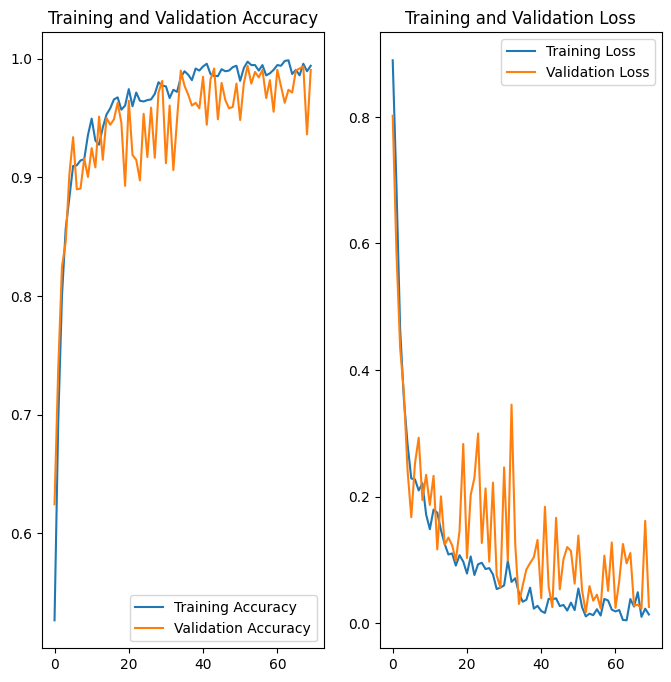

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(70),acc,label='Training Accuracy')
plt.plot(range(70),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(70),loss,label='Training Loss')
plt.plot(range(70),vAL_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 144ms/step
Predict label Potato___Early_blight


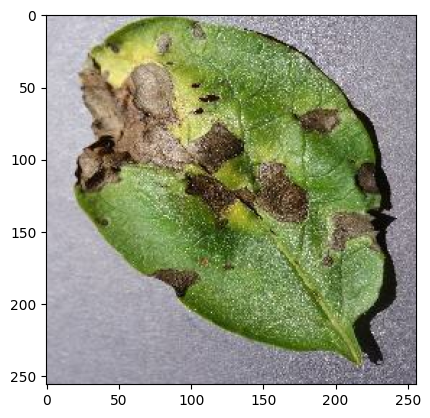

In [37]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:" ,class_names[first_label])
  batch_prediction=model.predict(image_batch)
  print("Predict label",class_names[np.argmax(batch_prediction[0])])


In [40]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)# create a batch
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 17ms/step


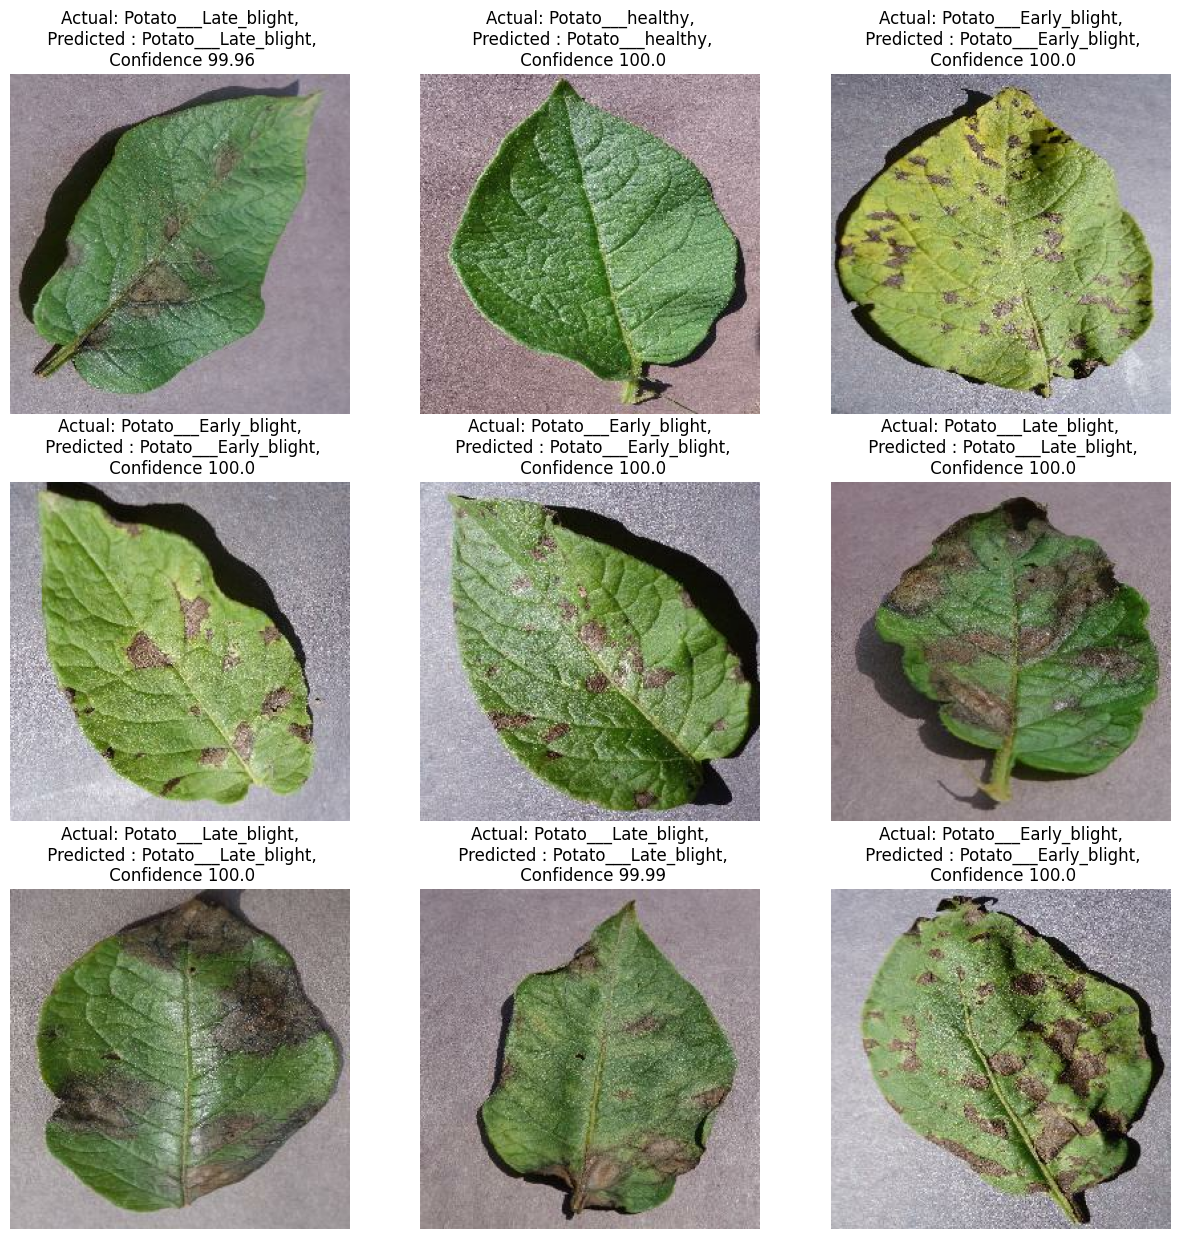

In [47]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted : {predicted_class},\n Confidence {confidence}")
    plt.axis("off")

In [49]:
model_version=1
model.save("")

In [53]:
import shutil
from google.colab import files

def download_folder_as_zip(folder_path):
    shutil.make_archive('/content/assets', 'zip', folder_path)
    files.download('/content/assets.zip')

# Example usage:
folder_path = '/content/assets'  # Replace with the path to your folder in Colab
download_folder_as_zip(folder_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")